In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

from statannotations.Annotator import Annotator
import pyBigWig

In [2]:
def compute_relative_dispersions(
    preds: np.ndarray, lowess_delta: float = 0.05, method: str = "seurat_v3", as_percentile: bool = True
) -> np.ndarray:
    """
    Parameters: 
        preds (np.ndarray): array of shape [..., n_replicates]
    Return:
        dispersions (np.ndarray): array of shape [...]
    """
    assert method in ["simple", "seurat_v3"]
                        
    means = np.mean(preds, axis=-1).flatten()
    variances = np.var(preds, axis=-1).flatten()
    log_means = np.log10(means)
    log_variances = np.log10(variances)
    smoothed_log_variances = sm.nonparametric.lowess(
        log_variances, log_means, delta=lowess_delta, return_sorted=False
    )
    if method == "simple":
        dispersions = log_variances - smoothed_log_variances
    elif method == "seurat_v3":
        smoothed_std = np.sqrt(np.power(10, smoothed_log_variances))
        smoothed_std = np.reshape(smoothed_std, preds.shape[: -1])
        normalized_preds = preds - np.mean(preds, axis=-1)[..., np.newaxis]
        normalized_preds = normalized_preds / smoothed_std[..., np.newaxis]
        dispersions = np.var(normalized_preds, axis=-1)
        
    if as_percentile:
        ranks = stats.rankdata(dispersions.flatten())
        percentiles = ranks / ranks.size * 100.0
        return np.reshape(percentiles, preds.shape[: -1])
    else:
        return dispersions

In [3]:
all_tissue = pd.read_csv('all_tissue_eqtl_preds_CAGE.csv')

In [4]:
all_tissue.columns

Index(['chr', 'pos', 'variant', 'ref', 'alt', '.', '..', '...', 'SAD scores',
       'SAD signs', 'SAD magnitudes', 'SAD mean', 'SAD mean magnitude',
       'chromosome', 'start', 'end', 'allele1', 'allele2', 'minor_allele',
       'tissue', 'gene', 'maf', 'beta_marginal', 'se_marginal', 'z', 'pip',
       'cs_id', 'beta_posterior', 'sd_posterior', 'snp', 'variant_hg19',
       'name', 'chrom', 'txStart', 'eQTL direction', 'eQTL effect size',
       'eQTL effect size magnitude', 'TSS distance', 'TSS distance magnitude',
       'SAD sign majority vote', 'SAD sign replicate 1', 'phyloP', 'TSS bin',
       'fraction sign agreement eQTL direction',
       'fraction sign agreement among reps',
       'num sign agreement eQTL direction', 'num sign agreement among reps',
       '(label sign agreement, rep sign agreement)', 'agreement summary',
       'DNase track', 'CAGE track', 'sign agreement'],
      dtype='object')

In [5]:
cols_of_interest = ['variant', 'ref', 'alt', 'SAD scores',
                    'SAD signs', 'SAD magnitudes', 'SAD mean', 'SAD mean magnitude',
                    'allele1', 'allele2', 'minor_allele',
                    'tissue', 'gene', 'variant_hg19',
                    'eQTL direction', 'eQTL effect size', 'eQTL effect size magnitude',
                    'TSS distance', 'TSS distance magnitude',
                    'SAD sign majority vote', 'num sign agreement eQTL direction', 'num sign agreement among reps',
                    'sign agreement']
all_tissue = all_tissue[cols_of_interest]
all_tissue.rename(columns={"num sign agreement eQTL direction": "num sign correct",
                           "num sign agreement among reps": "num sign agree"})

,variant,ref,alt,SAD scores,SAD signs,SAD magnitudes,SAD mean,SAD mean magnitude,allele1,allele2,...,variant_hg19,eQTL direction,eQTL effect size,eQTL effect size magnitude,TSS distance,TSS distance magnitude,SAD sign majority vote,num sign correct,num sign agree,sign agreement
0,chr10_101031042_C_A_b38,C,A,"[-15.0, -14.3125, -20.625, -14.15625, -13.3125]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[15.0, 14.3125, 20.625, 14.15625, 13.3125]",-15.481250,15.481250,C,A,...,chr10_102790799_C_A,False,-0.253829,0.253829,-23206,23206,-1.0,5,5,Consistently correct
1,chr10_101032154_C_A_b38,C,A,"[0.75, 2.34375, -2.125, -0.109375, 3.65625]","[1.0, 1.0, -1.0, -1.0, 1.0]","[0.75, 2.34375, 2.125, 0.109375, 3.65625]",0.903125,1.796875,C,A,...,chr10_102791911_C_A,True,0.168667,0.168667,-921,921,1.0,3,3,Inconsistent
2,chr10_101035974_G_A_b38,G,A,"[0.07421875, 0.0283203125, 0.095703125, 0.0332...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.07421875, 0.0283203125, 0.095703125, 0.0332...",0.124414,0.124414,G,A,...,chr10_102795731_G_A,False,-0.179033,0.179033,-4741,4741,1.0,0,5,Consistently incorrect
3,chr10_102744807_C_T_b38,C,T,"[-0.01806640625, -0.015625, -0.052734375, -0.0...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.01806640625, 0.015625, 0.052734375, 0.05859...",-0.041455,0.041455,C,T,...,chr10_104504564_C_T,False,-0.373464,0.373464,-838,838,-1.0,5,5,Consistently correct
4,chr10_104267428_A_T_b38,A,T,"[-0.006103515625, -0.014404296875, 0.0078125, ...","[-1.0, -1.0, 1.0, 1.0, 1.0]","[0.006103515625, 0.014404296875, 0.0078125, 0....",0.003223,0.011426,A,T,...,chr10_106027186_A_T,False,-0.703667,0.703667,-32073,32073,1.0,2,3,Inconsistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540,chr9_65306506_A_C_b38,A,C,"[0.0016326904296875, 0.0001373291015625, 0.001...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.0016326904296875, 0.0001373291015625, 0.001...",0.000987,0.000987,A,C,...,chr9_70200112_A_C,True,0.787293,0.787293,-18593,18593,1.0,5,5,Consistently correct
8541,chrX_149527012_G_T_b38,T,G,"[-0.001678466796875, -0.005279541015625, -0.00...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.001678466796875, 0.005279541015625, 0.00378...",-0.002856,0.002856,G,T,...,chrX_148608551_T_G,False,-1.053540,1.053540,-15504,15504,-1.0,5,5,Consistently correct
8542,chrX_151695519_C_T_b38,C,T,"[-0.111083984375, -0.236328125, -0.20556640625...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.111083984375, 0.236328125, 0.20556640625, 0...",-0.176611,0.176611,C,T,...,chrX_150863991_C_T,False,-0.328463,0.328463,-396,396,-1.0,5,5,Consistently correct
8543,chrX_2615840_C_G_b38,C,G,"[-0.0035400390625, 0.00830078125, 0.029296875,...","[-1.0, 1.0, 1.0, 1.0, 1.0]","[0.0035400390625, 0.00830078125, 0.029296875, ...",0.016162,0.017578,C,G,...,chrX_2533881_C_G,False,-0.739483,0.739483,-2853,2853,1.0,1,4,Inconsistent


In [6]:
from ast import literal_eval

num_eqtls = all_tissue.shape[0]
preds = all_tissue['SAD scores'].tolist()
preds = np.array([literal_eval(p) for p in preds])

assert(preds.shape == (num_eqtls, 5))

In [7]:
#sad mean and var from sign majority vote only
preds.tolist()
maj_signs = [np.sign(np.sum(np.sign(p))) for p in preds]

maj_sign_preds = []
for i in range(len(preds)):
    sign = maj_signs[i]
    maj_sign_preds.append([q for q in preds[i] if np.sign(q)==sign])
print(maj_sign_preds)

all_tissue['SAD mean majority sign'] = [np.mean(p) for p in maj_sign_preds]
all_tissue['SAD var majority sign'] = [np.var(p) for p in maj_sign_preds]

all_tissue['SAD sd majority sign'] = np.sqrt(all_tissue['SAD var majority sign'].to_numpy())

[[-15.0, -14.3125, -20.625, -14.15625, -13.3125], [0.75, 2.34375, 3.65625], [0.07421875, 0.0283203125, 0.095703125, 0.033203125, 0.390625], [-0.01806640625, -0.015625, -0.052734375, -0.05859375, -0.062255859375], [0.0078125, 0.02099609375, 0.0078125], [1.9375, 0.75, 2.1875, 0.765625, 2.125], [-0.001708984375, -0.009521484375, -0.0126953125, -0.00439453125], [-0.00067138671875, -0.001129150390625, -0.001953125, -0.000701904296875], [0.015625, 0.00390625, 0.048828125], [-4.5, -2.9375, -3.125, -6.875], [0.13720703125, 0.00439453125, 0.02392578125, 0.1328125, 0.1416015625], [-0.00732421875, -0.00244140625, -0.0166015625], [-0.0205078125, -0.0087890625, -0.02294921875, -0.020751953125], [0.001708984375, 0.00067138671875, 0.0009765625], [0.006103515625, 0.008544921875, 0.0047607421875, 0.0078125], [7.375, 15.125, 21.3125, 5.3125], [0.0], [0.052734375, 0.19140625, 0.91015625, 0.05078125, 0.4873046875], [0.0166015625, 0.046875, 0.0244140625, 0.02197265625, 0.025390625], [0.0517578125, 0.138183

In [8]:
# variances
variances = np.var(preds, axis=-1).flatten()
all_tissue['var'] = variances

In [9]:
# dispersions
for m in ["simple", "seurat_v3"]:
    disps = compute_relative_dispersions(preds, method=m)
    all_tissue['disp_{}'.format(m)] = disps

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


In [10]:
all_tissue

,variant,ref,alt,SAD scores,SAD signs,SAD magnitudes,SAD mean,SAD mean magnitude,allele1,allele2,...,SAD sign majority vote,num sign agreement eQTL direction,num sign agreement among reps,sign agreement,SAD mean majority sign,SAD var majority sign,SAD sd majority sign,var,disp_simple,disp_seurat_v3
0,chr10_101031042_C_A_b38,C,A,"[-15.0, -14.3125, -20.625, -14.15625, -13.3125]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[15.0, 14.3125, 20.625, 14.15625, 13.3125]",-15.481250,15.481250,C,A,...,-1.0,5,5,Consistently correct,-15.481250,6.902969e+00,2.627350,6.902969e+00,53.259216,53.259216
1,chr10_101032154_C_A_b38,C,A,"[0.75, 2.34375, -2.125, -0.109375, 3.65625]","[1.0, 1.0, -1.0, -1.0, 1.0]","[0.75, 2.34375, 2.125, 0.109375, 3.65625]",0.903125,1.796875,C,A,...,1.0,3,3,Inconsistent,2.250000,1.412109e+00,1.188322,3.974648e+00,42.340550,42.340550
2,chr10_101035974_G_A_b38,G,A,"[0.07421875, 0.0283203125, 0.095703125, 0.0332...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.07421875, 0.0283203125, 0.095703125, 0.0332...",0.124414,0.124414,G,A,...,1.0,0,5,Consistently incorrect,0.124414,1.835312e-02,0.135474,1.835312e-02,29.233470,29.233470
3,chr10_102744807_C_T_b38,C,T,"[-0.01806640625, -0.015625, -0.052734375, -0.0...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.01806640625, 0.015625, 0.052734375, 0.05859...",-0.041455,0.041455,C,T,...,-1.0,5,5,Consistently correct,-0.041455,4.135704e-04,0.020336,4.135704e-04,77.741369,77.741369
4,chr10_104267428_A_T_b38,A,T,"[-0.006103515625, -0.014404296875, 0.0078125, ...","[-1.0, -1.0, 1.0, 1.0, 1.0]","[0.006103515625, 0.014404296875, 0.0078125, 0....",0.003223,0.011426,A,T,...,1.0,2,3,Inconsistent,0.012207,3.862381e-05,0.006215,1.511431e-04,44.119368,44.119368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540,chr9_65306506_A_C_b38,A,C,"[0.0016326904296875, 0.0001373291015625, 0.001...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.0016326904296875, 0.0001373291015625, 0.001...",0.000987,0.000987,A,C,...,1.0,5,5,Consistently correct,0.000987,3.988063e-07,0.000632,3.988063e-07,7.396138,7.396138
8541,chrX_149527012_G_T_b38,T,G,"[-0.001678466796875, -0.005279541015625, -0.00...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.001678466796875, 0.005279541015625, 0.00378...",-0.002856,0.002856,G,T,...,-1.0,5,5,Consistently correct,-0.002856,3.182366e-06,0.001784,3.182366e-06,57.647747,57.647747
8542,chrX_151695519_C_T_b38,C,T,"[-0.111083984375, -0.236328125, -0.20556640625...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.111083984375, 0.236328125, 0.20556640625, 0...",-0.176611,0.176611,C,T,...,-1.0,5,5,Consistently correct,-0.176611,2.672138e-03,0.051693,2.672138e-03,57.636044,57.636044
8543,chrX_2615840_C_G_b38,C,G,"[-0.0035400390625, 0.00830078125, 0.029296875,...","[-1.0, 1.0, 1.0, 1.0, 1.0]","[0.0035400390625, 0.00830078125, 0.029296875, ...",0.016162,0.017578,C,G,...,1.0,1,4,Inconsistent,0.021088,6.065797e-05,0.007788,1.455700e-04,19.707431,19.707431


In [11]:
all_tissue.to_csv('all_tissue_eqtl_preds_CAGE_subset.csv', index=False)

# Plotting

#### Starting with just plotting the means and std devs (as determined by only the replicates winning the majority vote)

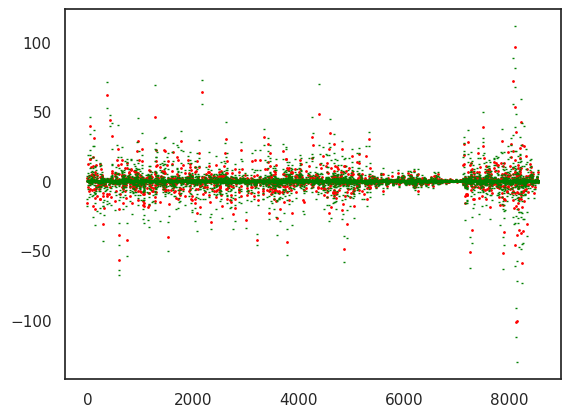

In [157]:
# just plot SAD mean and var confidence intervals for each variant

sns.set(style='white')
sns.set_palette('pastel')
plt.figure()

idxs = range(num_eqtls)
mean = all_tissue['SAD mean majority sign'].to_numpy()
var = all_tissue['SAD var majority sign'].to_numpy()
upper = mean+np.sqrt(var)
lower = mean-np.sqrt(var)

plt.plot(idxs, mean, marker='o', markersize='1', linewidth=0, color='red')
plt.plot(idxs, upper, marker='_', markersize='1', linewidth=0, color='green')
plt.plot(idxs, lower, marker='_', markersize='1', linewidth=0, color='green')

In [210]:
def plot_errorbars_using_majority_conformal(df, title, path, sort_type='cat'):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    ax0, ax1 = axs
    fig.suptitle(title)
    
    assert sort_type in ['cat', 'num']
    if sort_type=='cat':
        agree_sort_dict = {'Consistently incorrect': 0, 'Inconsistent': 1, 'Consistently correct': 2} 
        df = df.sort_values(by=['sign agreement'], key=lambda x: x.map(agree_sort_dict))
        col_title = 'sign agreement'
        sort_list = ['Consistently incorrect', 'Inconsistent', 'Consistently correct']
    else:
        df = df.sort_values(by=['num sign agreement eQTL direction'])
        col_title = 'num sign agreement eQTL direction'
        sort_list = df['num sign agreement eQTL direction'].unique().tolist()
    
    coverage, conf_coverage = {}, {}
    both_signs_cov, conf_both_signs_cov = {}, {}
    
    i = 0
    print(sort_list)
    for agreement in sort_list:
        agreement_subset_df = df[df[col_title]==agreement]
        agreement_subset_df = agreement_subset_df.sort_values(by=['SAD mean majority sign'])
        agreement_neqtls = len(agreement_subset_df)
        
        # fetch relevant columns
        label = agreement_subset_df['eQTL effect size'].to_numpy() 
        mean = agreement_subset_df['SAD mean majority sign'].to_numpy()
        var = agreement_subset_df['SAD var majority sign'].to_numpy()
        sd = np.sqrt(var)
        
        # calculate conformal intervals using sd of majority vote ensemble as uncertainty scalar
        cal_frac = 0.1
        alpha = 0.5 # 1-alpha is the desired coverage
        cal_n = np.floor(cal_frac*agreement_neqtls).astype(int)
        idx = np.array([1] * cal_n + [0] * (label.shape[0]-cal_n)) > 0
        np.random.shuffle(idx)

        cal_label, val_label = label[idx], label[~idx]
        cal_pred, val_pred = mean[idx], mean[~idx]
        cal_U, val_U = sd[idx], sd[~idx] #using sd
        # Calculate scores
        assert(cal_pred.shape==cal_label.shape)
        cal_scores = np.abs(cal_pred-cal_label)/cal_U
        # Get score quantile
        qhat = np.quantile(cal_scores, np.ceil((cal_n+1)*(1-alpha))/cal_n, interpolation='higher')
        # Apply
        pred_sets = [val_pred - val_U*qhat, val_pred + val_U*qhat]
        
        # naive stats
        uncal_pred_sets = [val_pred - val_U, val_pred + val_U]
        covered_count = (val_label >= uncal_pred_sets[0]) & (val_label <= uncal_pred_sets[1]) 
        both_signs_count = np.sign(val_label-val_U) != np.sign(val_label+val_U)

        coverage[agreement] = covered_count.mean()
        both_signs_cov[agreement] = both_signs_count.mean()
        
        # naive plot
        # plot means from majority sign vote along with errors from std dev
        ax0.errorbar(range(i,i+len(val_pred)), val_pred, val_U, linestyle='None', marker='o', label=agreement)
            
        # conformal stats
        conf_covered_count = (val_label >= pred_sets[0]) & (val_label <= pred_sets[1]) 
        conf_both_signs_count = np.sign(pred_sets[0]) != np.sign(pred_sets[1])

        conf_coverage[agreement] = conf_covered_count.mean()
        conf_both_signs_cov[agreement] = conf_both_signs_count.mean()
            
        # conformal plot
        # plot means from majority sign vote along with errors from conformal
        ax1.errorbar(range(i,i+len(val_pred)), val_pred, val_U*qhat, linestyle='None', marker='^', label=agreement)
        
        # update i
        i += len(val_pred)
    
    ax0.get_xaxis().set_visible(False)
    ax0.legend()
    plt.savefig(path)
 
    return coverage, both_signs_cov, conf_coverage, conf_both_signs_cov

In [203]:
def plot_errorbars_using_majority_naive(df, title):
    plt.figure()

    df = df.sort_values(by=['num sign agreement eQTL direction'])
    
    coverage = {}
    both_signs_cov = {}
    i = 0
    for agreement in df['num sign agreement eQTL direction'].unique().tolist():
        
        agreement_subset_df = df[df['num sign agreement eQTL direction']==agreement]
        agreement_subset_df = agreement_subset_df.sort_values(by=['SAD mean majority sign'])
        agreement_neqtls = len(agreement_subset_df)
        
        idxs = range(i, i+agreement_neqtls, 1)
        label = agreement_subset_df['eQTL effect size'].to_numpy() 
        mean = agreement_subset_df['SAD mean majority sign'].to_numpy()
        var = agreement_subset_df['SAD var majority sign'].to_numpy()
        sd = np.sqrt(var)
        
        covered_count = (label >= (mean-sd)) & (label <= (mean+sd))  
        both_signs_count = np.sign(mean-sd) != np.sign(mean+sd)
        coverage[agreement] = covered_count.mean()
        both_signs_cov[agreement] = both_signs_count.mean()

        # plot means from majority sign vote along with errors from std dev
        plt.errorbar(idxs, mean, sd, linestyle='None', marker='o', label='{} correct'.format(agreement))
        i += agreement_neqtls
    
    plt.legend(ncol=2)
    plt.title(title)
    #plt.show()
    return coverage, both_signs_cov

['Consistently incorrect', 'Inconsistent', 'Consistently correct']


/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


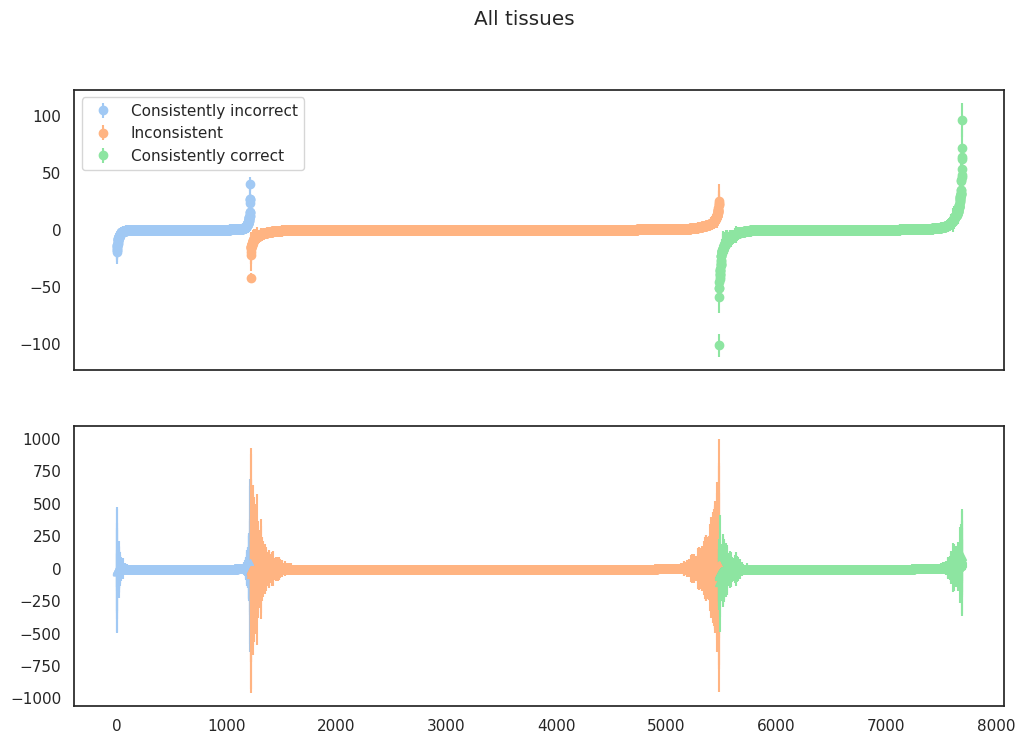

In [215]:
sort_by = 'cat'


cov_dict, both_dict, conf_cov_dict, conf_both_dict = plot_errorbars_using_majority_conformal(all_tissue,
                                                                                             'All tissues',
                                                                                             'figs/all_tissues_{}'.format(sort_by),
                                                                                             sort_type=sort_by)

In [216]:
print(cov_dict)
print(both_dict)
print('\n')
print(conf_cov_dict)
print(conf_both_dict)

{'Consistently incorrect': 0.0, 'Inconsistent': 0.054681999530626614, 'Consistently correct': 0.12697695436059647}
{'Consistently incorrect': 0.11986863711001643, 'Inconsistent': 0.13025111476179302, 'Consistently correct': 0.2254857659286037}


{'Consistently incorrect': 0.47783251231527096, 'Inconsistent': 0.5364937808026284, 'Consistently correct': 0.5286940804338003}
{'Consistently incorrect': 1.0, 'Inconsistent': 0.9875616052569819, 'Consistently correct': 0.9990962494351558}


In [ ]:
def plot_coverage_and_both_signs(sort_type, cd, bd, ccd, cbd):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    ax0, ax1 = axs
    fig.suptitle(title)
    
    if sort_type=='num':
        for i in range(6)
        ax0.plot(i, cd[i], linestyle='None', marker='o', label='{} correct'.format(i))
    
    ax0.legend()
    plt.show()

In [ ]:
cov_dict, both_dict, conf_cov_dict, conf_both_dict = plot_errorbars_using_majority_conformal(all_tissue,
                                                                                             'All tissues',
                                                                                             'figs/all_tissues_{}'.format(sort_by))

In [201]:
print(cov_dict)
print(both_dict)
print('\n')
print(conf_cov_dict)
print(conf_both_dict)

{'Consistently incorrect': 0.0, 'Inconsistent': 0.053743252757568645, 'Consistently correct': 0.13104383190239494}
{'Consistently incorrect': 0.11822660098522167, 'Inconsistent': 0.1300164280685285, 'Consistently correct': 0.22819701762313602}


{'Consistently incorrect': 0.5147783251231527, 'Inconsistent': 0.5458812485332082, 'Consistently correct': 0.5408947130591957}
{'Consistently incorrect': 1.0, 'Inconsistent': 0.9877962919502464, 'Consistently correct': 1.0}


{0: 0.0, 1: 0.004672897196261682, 2: 0.0, 3: 0.09818481848184818, 4: 0.10036630036630037, 5: 0.12978030919446704}
{0: 0.07760532150776053, 1: 0.09065420560747664, 2: 0.10487580496780129, 3: 0.08085808580858085, 4: 0.09304029304029304, 5: 0.07200976403580146}


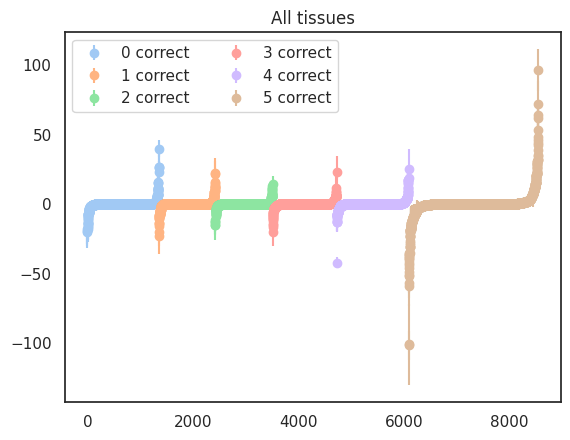

In [75]:
cov_dict, both_dict = plot_errorbars_using_majority_num(all_tissue, "All tissues")
plt.savefig('figs/all_tissues_num')
print(cov_dict)
print(both_dict)

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


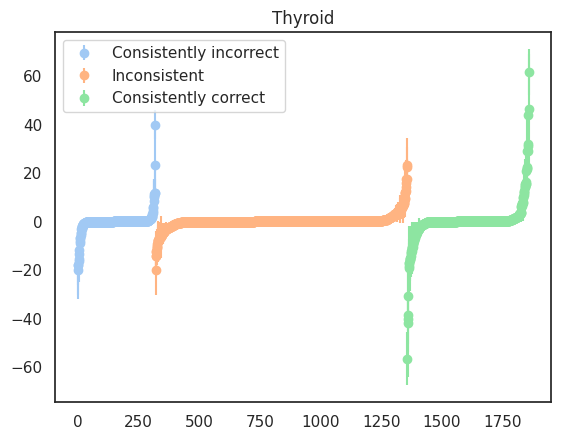

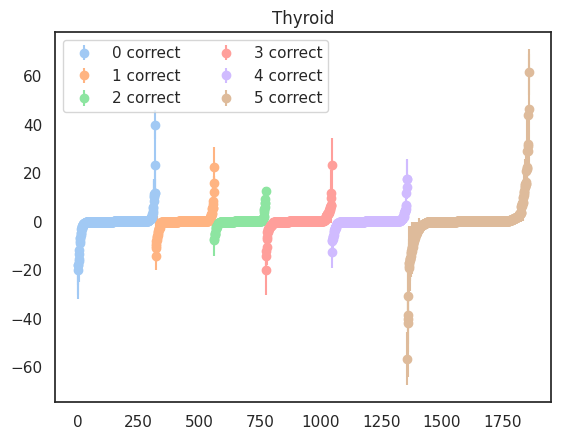

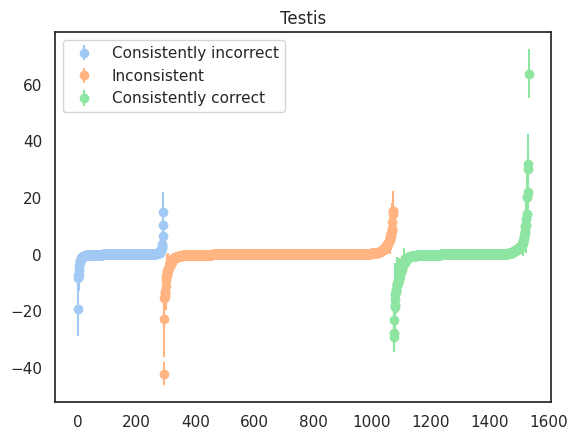

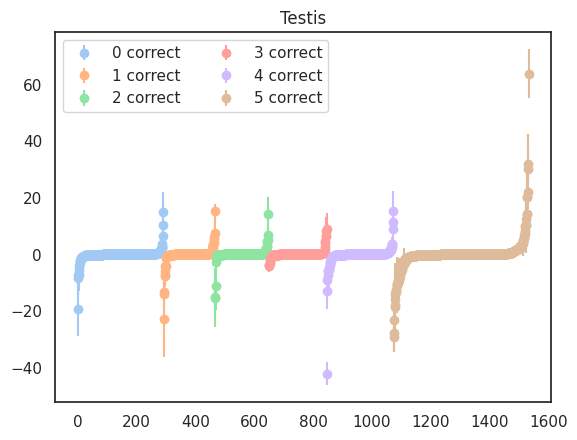

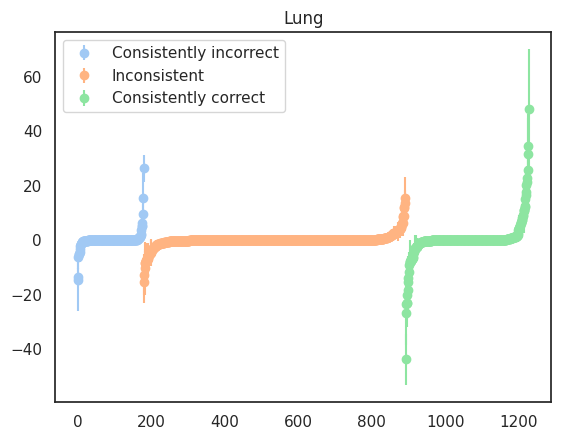

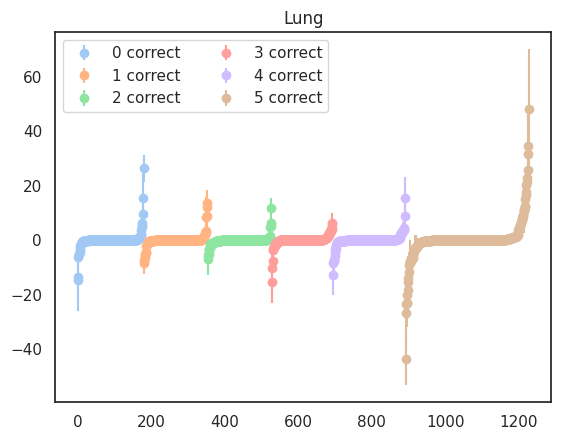

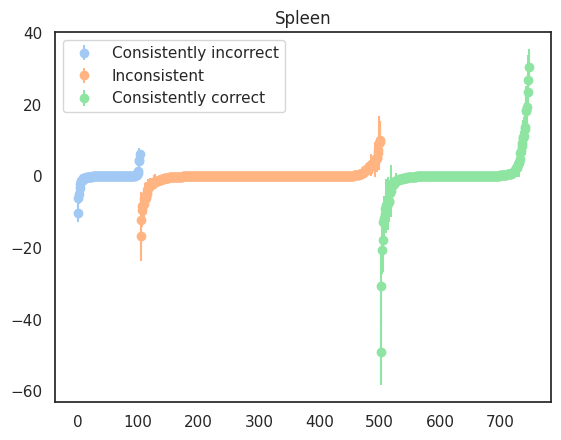

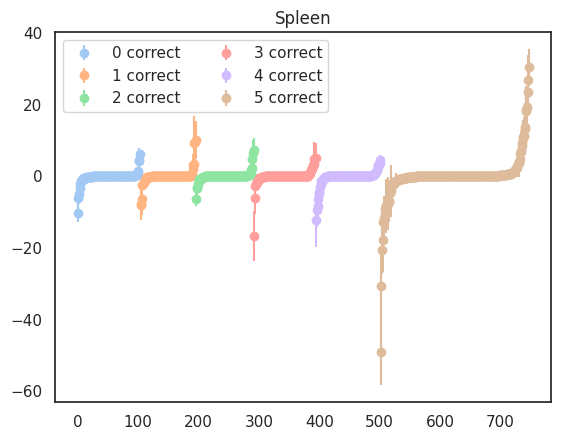

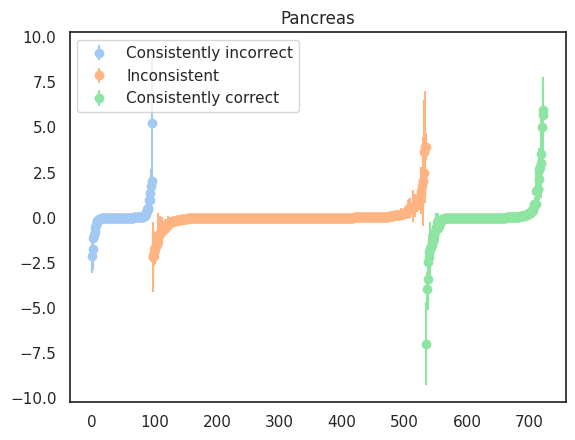

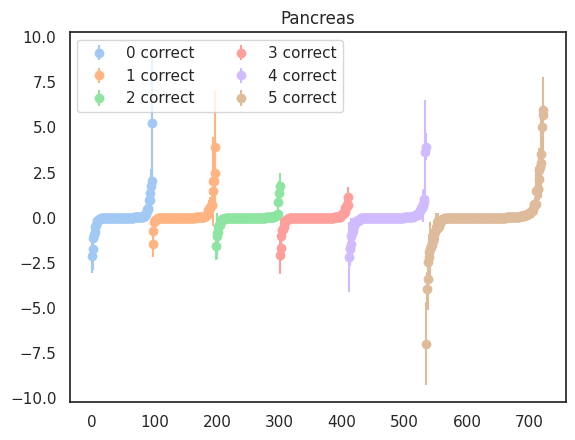

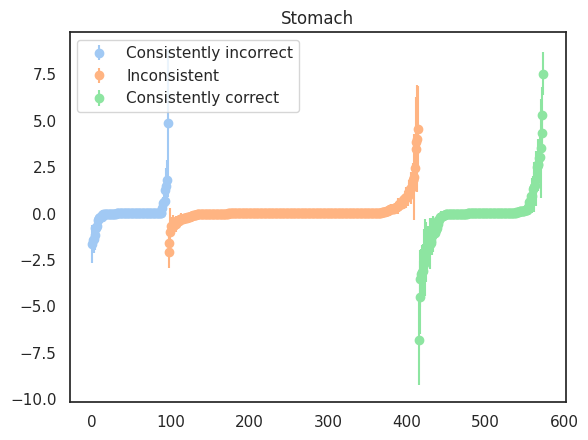

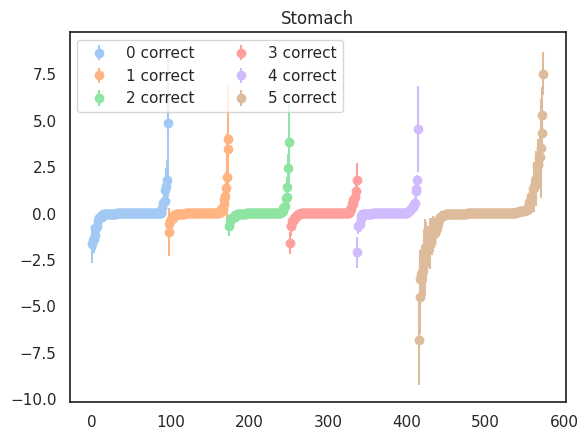

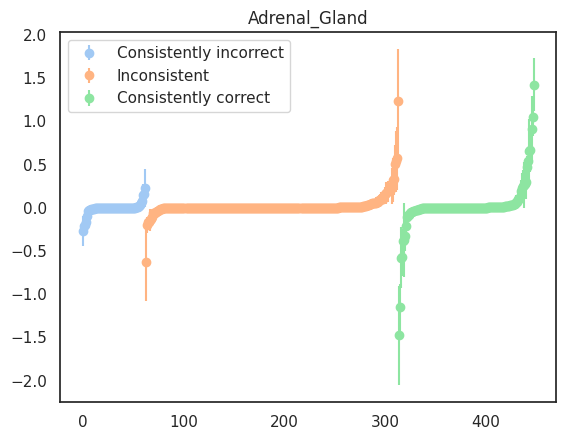

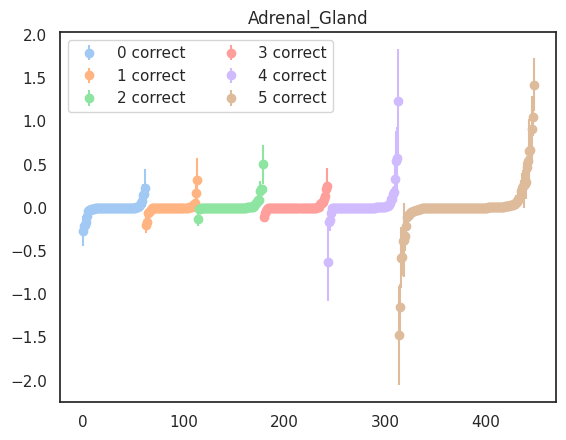

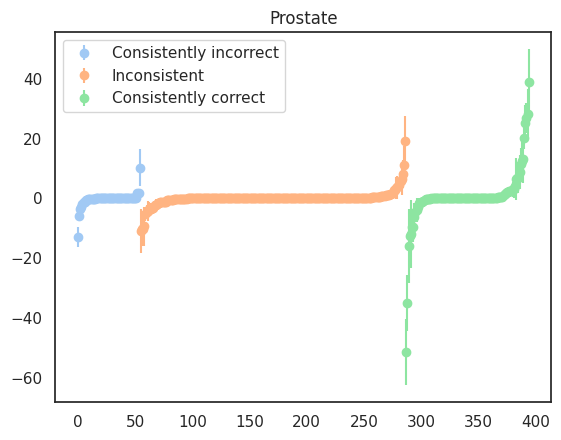

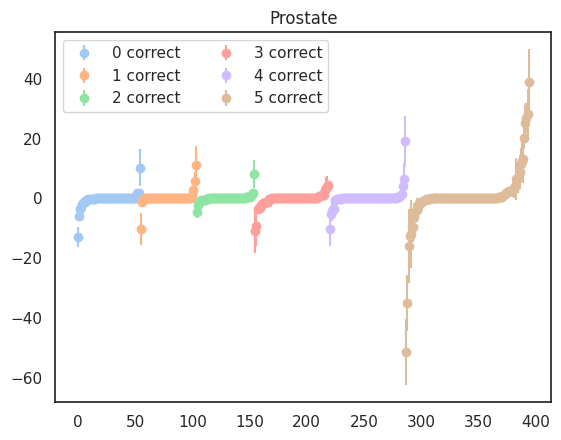

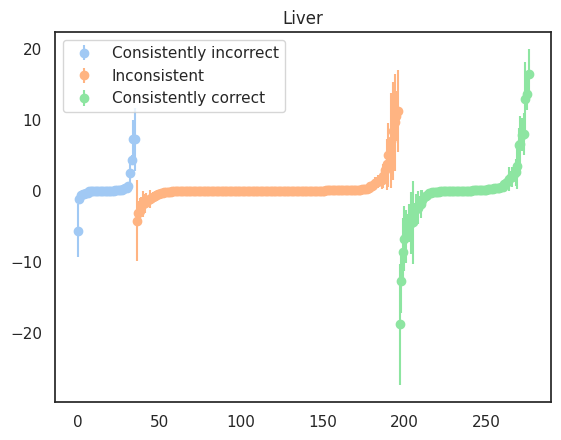

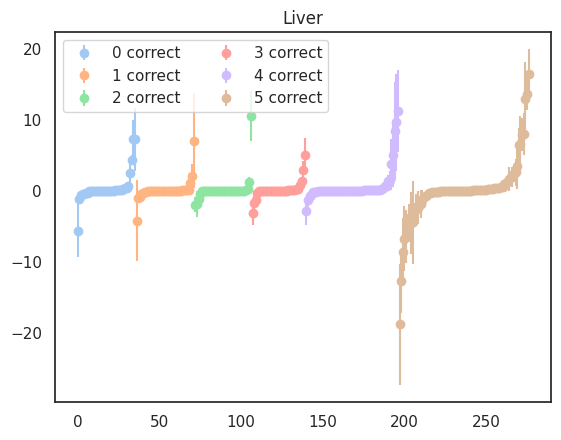

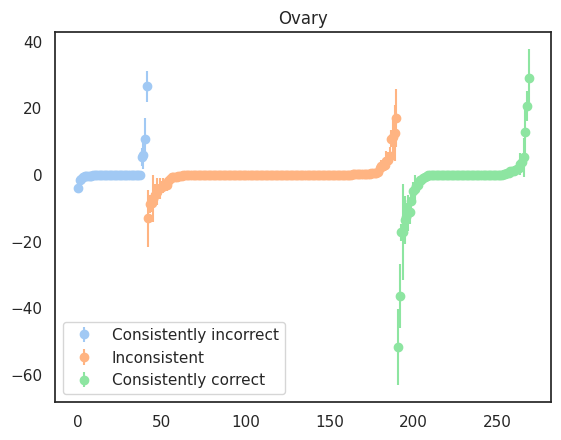

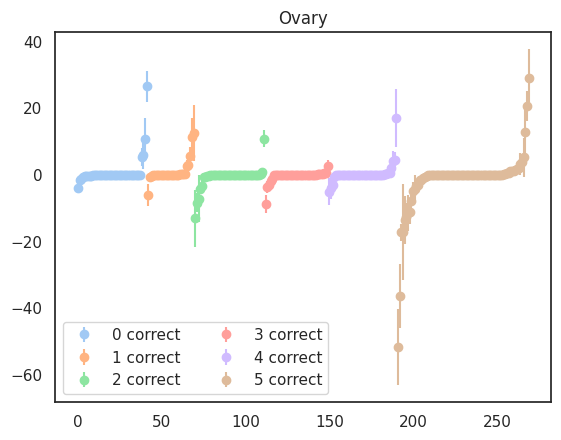

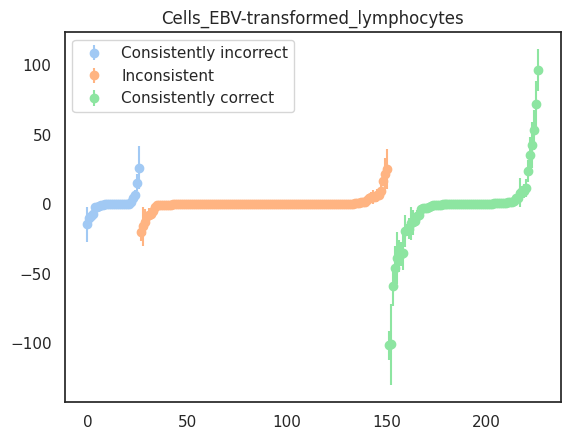

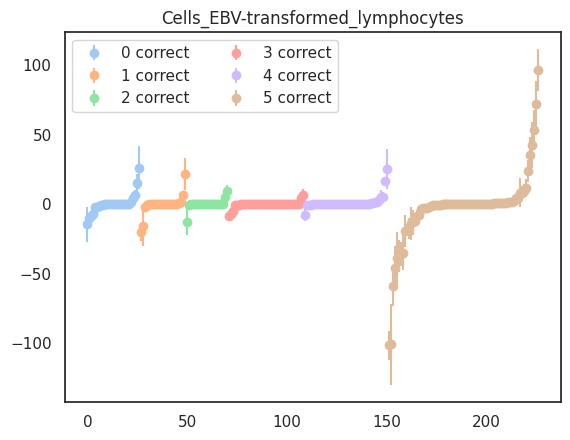

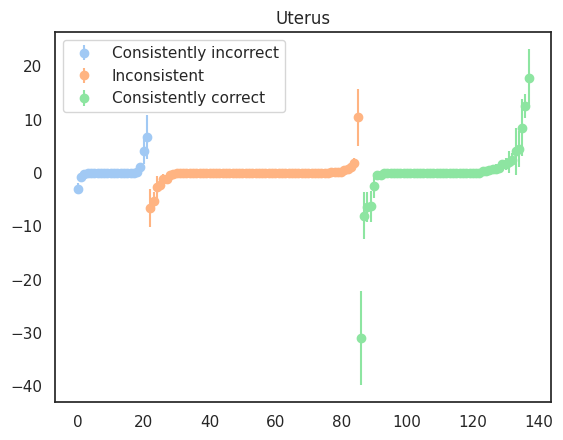

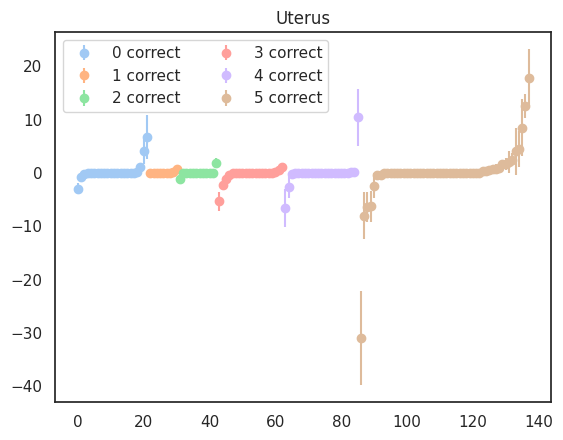

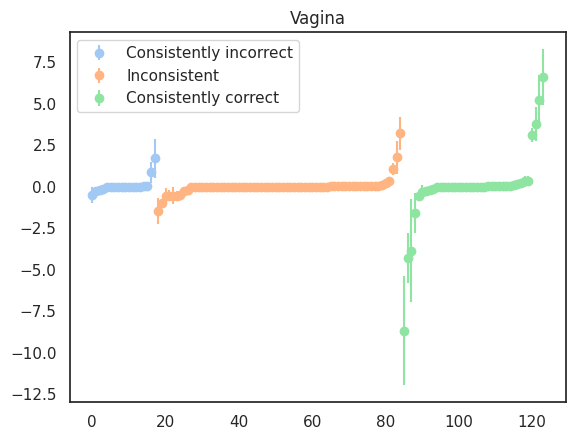

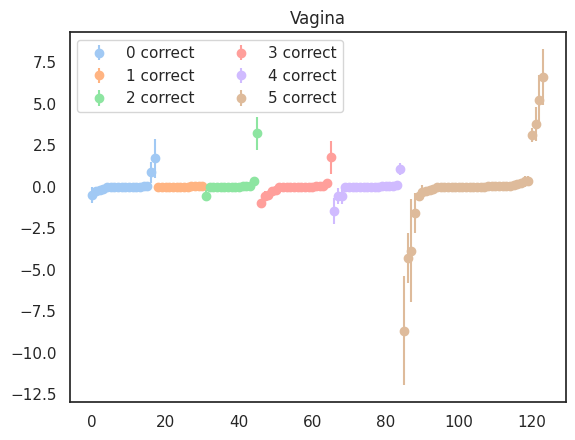

In [23]:
tissues = all_tissue['tissue'].unique().tolist()

for t in tissues:
    tissue_df = all_tissue[all_tissue['tissue']==t]
    plot_errorbars_using_majority_cat(tissue_df, t)
    plt.savefig('figs/{}_cat'.format(t))
    plot_errorbars_using_majority_num(tissue_df, t)
    plt.savefig('figs/{}_num'.format(t))

### Maybe dispersion is more interesting?

In [103]:
def plot_errorbars_using_majority_cat_disp(df, title):
    plt.figure()
    
    agree_sort_dict = {'Consistently incorrect': 0, 'Inconsistent': 1, 'Consistently correct': 2} 
    df = df.sort_values(by=['sign agreement'], key=lambda x: x.map(agree_sort_dict))
    
    i = 0
    for agreement in ['Consistently incorrect', 'Inconsistent', 'Consistently correct']:
        
        agreement_subset_df = df[df['sign agreement']==agreement]
        agreement_subset_df = agreement_subset_df.sort_values(by=['SAD mean majority sign'])
        agreement_neqtls = len(agreement_subset_df)
        
        idxs = range(i, i+agreement_neqtls, 1)
        mean = agreement_subset_df['SAD mean majority sign'].to_numpy()
        spread = agreement_subset_df['disp_simple'].to_numpy()

        # plot means from majority sign vote along with errors from std dev
        plt.errorbar(idxs, mean, spread, linestyle='None', marker='o', label=agreement)
        i += agreement_neqtls
    
    plt.legend()
    plt.title(title)
    plt.show()

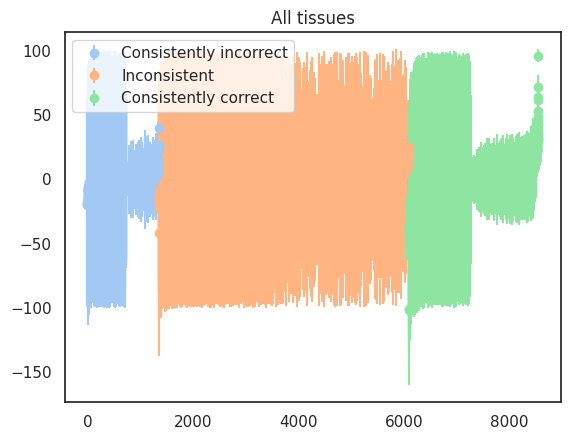

In [104]:
plot_errorbars_using_majority_cat_disp(all_tissue, "All tissues")

Dispersion is high in most cases, seems to be where effect sizes are low, but still high in some of the consistent cases.

In [107]:
def plot_errorbars_using_majority_num_disp(df, title):
    plt.figure()

    df = df.sort_values(by=['num sign agreement eQTL direction'])
    
    i = 0
    for agreement in df['num sign agreement eQTL direction'].unique().tolist():
        
        agreement_subset_df = df[df['num sign agreement eQTL direction']==agreement]
        agreement_subset_df = agreement_subset_df.sort_values(by=['SAD mean majority sign'])
        agreement_neqtls = len(agreement_subset_df)
        
        idxs = range(i, i+agreement_neqtls, 1)
        mean = agreement_subset_df['SAD mean majority sign'].to_numpy()
        spread = agreement_subset_df['disp_simple'].to_numpy()

        # plot means from majority sign vote along with errors from std dev
        plt.errorbar(idxs, mean, spread, linestyle='None', marker='o', label='{} correct'.format(agreement))
        i += agreement_neqtls
    
    plt.legend(ncol=2)
    plt.title(title)
    plt.show()

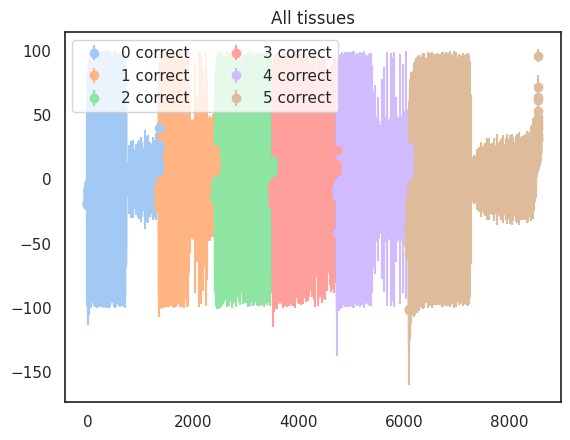

In [108]:
plot_errorbars_using_majority_num_disp(all_tissue, "All tissues")